# Validate Model and Visulize the Result

In [6]:
# Imports and configuration
import torch
import numpy as np
import os
import config
import net
from Dataset import *
from utils import data_transforms
import torch.nn.functional as F

# model = net.FCNet()
model = net.SiameseResNet()
# model_file = 'FCNet_2018-10-01-17-25_best.pth'
model_file = 'SiameseResNet_2024-05-22-22-34_best.pth'
dataset_type = 'h5' # or img?

/home/isr-lab3/miniconda3/envs/deepsim/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/isr-lab3/miniconda3/envs/deepsim/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Load models
model_path = os.path.join(config.MODEL_DIR, model_file)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

SiameseResNet(
  (model_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [8]:
# Load datasets
batch_size = 1
if dataset_type == 'h5':
    feature_file = config.FULL_RESIZED_FEATURE
    # image_datasets = {x: SatUAVDataset(csv_file=os.path.join(config.MID_PRODUCT, '%s.csv' % x),
    #                                      feature_file=feature_file) for x in ['train', 'val']}
    image_datasets = {x: SatUAVDataset(csv_meta='raw.csv', # evaluate does not run on augmented data
                             csv_file=f'{x}.csv',
                             root_dir=config.DATA_DIR,
                              transform=data_transforms['norm']) for x in ['train', 'val']
    }
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
else:
    print("Load Data Fail")

In [9]:
# Predict and get prediction matrix
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}#.cuda()
label_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}
# print(pred_matrix['val'].shape)
import time
since = time.time()
for phase in ['train', 'val']:
    print(phase,"phase:")
    for i_batch, sample_batched in enumerate(dataloaders[phase]):
        print(i_batch+1, '/', dataset_sizes[phase], end = '\r')
        A = sample_batched['A'].to(device)
        B = sample_batched['B'].to(device)
        #labels = sample_batched['label'].to(device)
        with torch.set_grad_enabled(False):
            outputs = model(A,B)
            #print(output_matrix[phase])
            #print(outputs[0])
            dist = F.pairwise_distance(outputs[0], outputs[1])
            output_matrix[phase][i_batch] = dist.cpu().data.numpy()[:, np.newaxis]
            label_matrix[phase][i_batch] = sample_batched['label'].numpy()[0]
            #[i_batch]
    print()
print((time.time()-since)/(192+48), 'seconds/image (Only time for FC layers)')

train phase:
688 / 688
val phase:
172 / 172
0.06174003978570302 seconds/image (Only time for FC layers)


In [13]:
pred_matrix = {x: (output_matrix[x] > 2)*1 for x in ['train', 'val']}
to_vis_matrix = {x: np.stack((output_matrix[x], pred_matrix[x], label_matrix[x])) for x in ['train', 'val']}
print({x: to_vis_matrix[x].shape for x in ['train', 'val']})


{'train': (3, 688), 'val': (3, 172)}


In [11]:
pred_matrix = {x: (output_matrix[x] > 0.5)*1 for x in ['train', 'val']}
print({x: output_matrix[x].shape for x in ['train', 'val']})
print({x: pred_matrix[x].shape for x in ['train', 'val']})
print({x: label_matrix[x].shape for x in ['train', 'val']})

to_vis_matrix = {x: np.concatenate((output_matrix[x], pred_matrix[x], label_matrix[x])) for x in ['train', 'val']}
print({x: to_vis_matrix[x].shape for x in ['train', 'val']})

{'train': (688,), 'val': (172,)}
{'train': (688,), 'val': (172,)}
{'train': (688,), 'val': (172,)}
{'train': (2064,), 'val': (516,)}


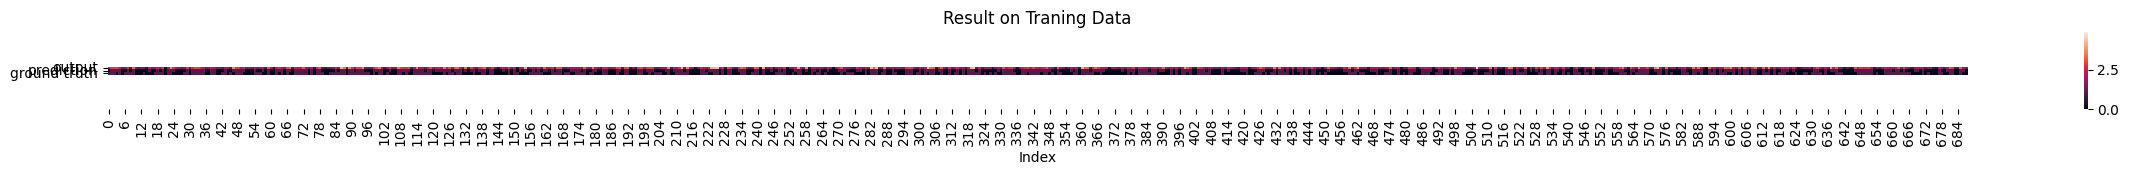

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

fig_size = [30,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['train'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Traning Data')
plt.show()

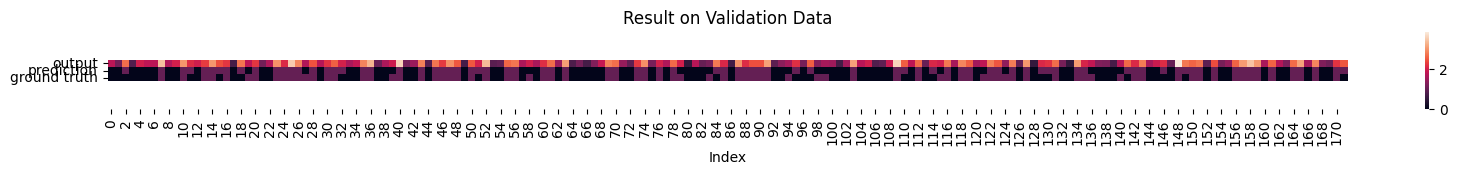

In [16]:
%matplotlib inline

fig_size = [20,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['val'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Validation Data')
plt.show()

In [17]:
# Analyse the result
def confusion_matrix(pred, gt):
    #n = gt.shape[0]
    P = gt == 1
    N = gt == 0
    
    TP = np.sum(pred[P])
    FP = np.sum(pred[N])
    FN = np.sum(1 - pred[P])
    TN = np.sum(1 - pred[N])
    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

for x in ['train', 'val']:
    print(x, 'data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:')
    print(confusion_matrix(pred_matrix[x], label_matrix[x]))

train data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(261, 93, 230, 104, 0.7150684931506849, 0.28792569659442724, 0.7136627906976745, 0.7372881355932204, 0.7150684931506849, 0.7260083449235049)
val data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(68, 17, 73, 14, 0.8292682926829268, 0.18888888888888888, 0.8197674418604651, 0.8, 0.8292682926829268, 0.8143712574850299)


In [19]:
max_distance = max(np.max(output_matrix['train']), np.max(output_matrix['val']))
max_distance

4.88961124420166

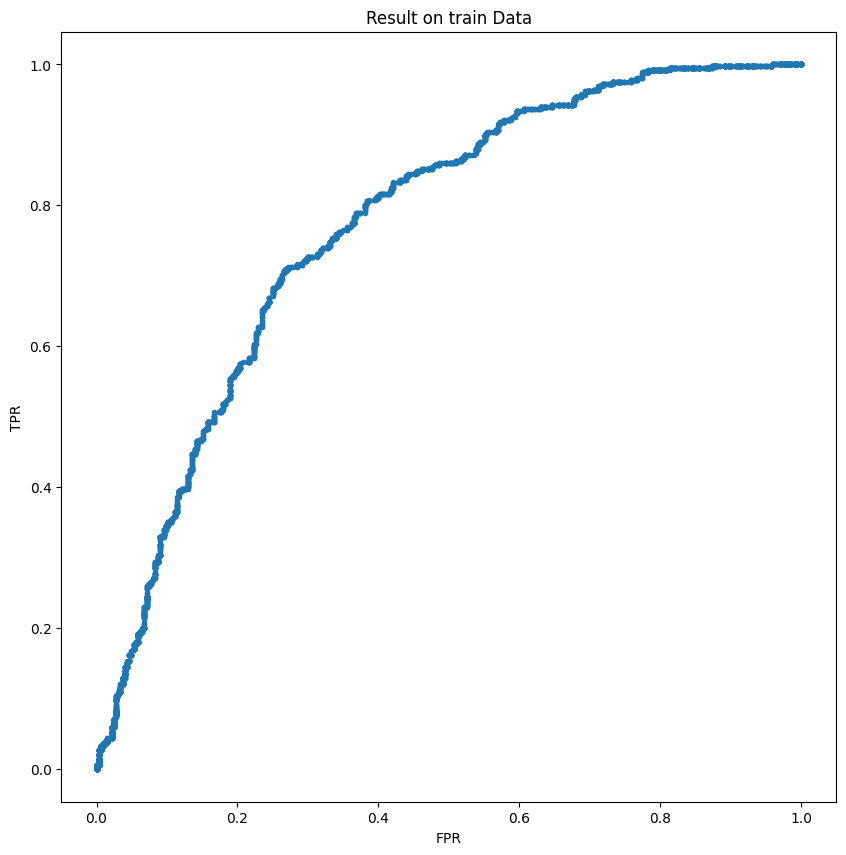

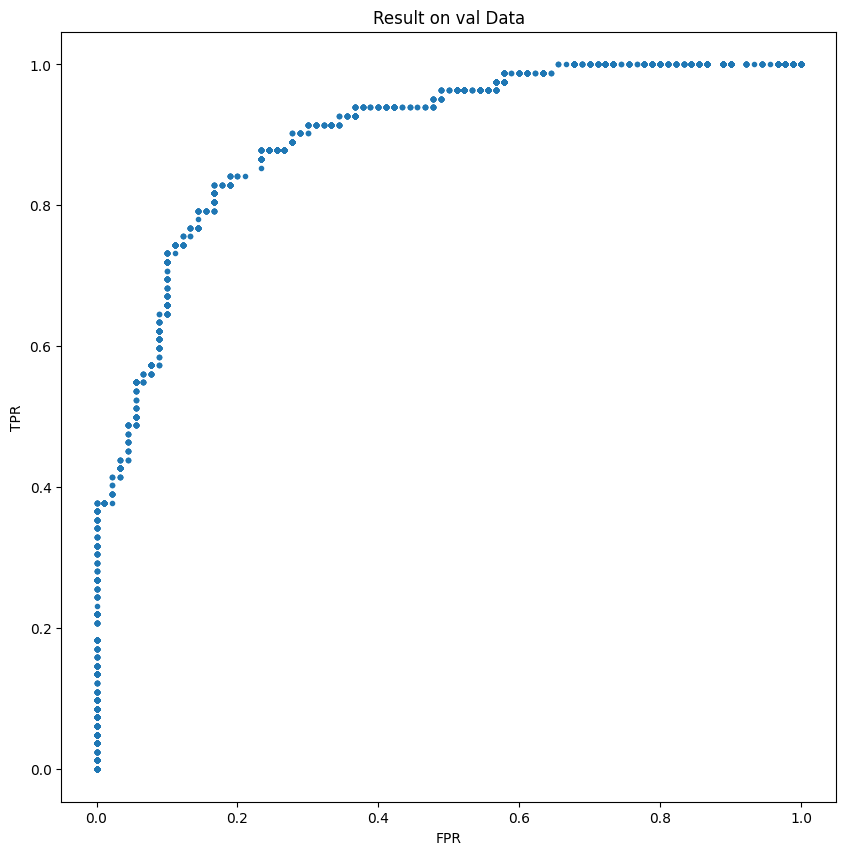

In [21]:
# ROC
np.seterr(divide='ignore',invalid='ignore')
phase = 'train'
for phase in ['train','val']:
    ROC_x, ROC_y = [0], [0]
    for threshold in range(1,1000*int(np.ceil(max_distance))+1):
        pred_matrix = (output_matrix[phase] > threshold/1000.0)*1
        conf_mat = confusion_matrix(pred_matrix, label_matrix[phase])
        x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
        ROC_x.append(x)
        ROC_y.append(y)
    #ROC_x.append(1)
    #ROC_y.append(1)
    #print(ROC_x,ROC_y)
    %matplotlib inline
    plt.gcf().clear()
    fig_size = [10,10]
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')
    plt.plot(ROC_x, ROC_y, '.')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.axis('equal')
    plt.title('Result on '+phase+' Data')
    axes = plt.gca()
    # axes.set_xlim([0., 1.])
    plt.show()


## Those wrong classified images

In [22]:
#
phase = 'train'
def sneaky_results(pred, gt):
    P = gt == 1
    N = gt == 0
    FP = np.logical_and(pred != gt, gt==0)
    FN = np.logical_and(pred != gt, gt==1)
    return np.where(FP)[0], np.where(FN)[0]
for x in ['train', 'val']:
    pred_matrix = (output_matrix[x] > .5)*1
    print(sneaky_results(pred_matrix, label_matrix[x]))

(array([  3,   5,  10,  11,  12,  14,  15,  16,  24,  25,  26,  27,  30,
        36,  37,  40,  41,  44,  46,  50,  51,  52,  53,  57,  58,  60,
        61,  63,  65,  67,  68,  74,  76,  80,  81,  88,  97,  99, 102,
       104, 105, 106, 109, 111, 112, 120, 121, 122, 123, 125, 128, 131,
       132, 133, 134, 136, 137, 140, 143, 144, 145, 146, 147, 149, 152,
       153, 154, 155, 161, 162, 163, 168, 171, 172, 177, 180, 181, 182,
       185, 186, 187, 189, 190, 193, 194, 195, 198, 199, 201, 205, 206,
       208, 209, 215, 216, 217, 218, 222, 223, 226, 228, 231, 232, 233,
       236, 237, 241, 243, 244, 245, 246, 252, 254, 257, 258, 259, 261,
       264, 266, 267, 269, 270, 272, 276, 277, 278, 279, 281, 285, 288,
       289, 292, 293, 294, 298, 301, 303, 306, 307, 309, 310, 312, 315,
       317, 323, 325, 329, 330, 337, 340, 345, 348, 350, 353, 354, 355,
       356, 359, 365, 366, 368, 369, 371, 372, 373, 374, 375, 376, 378,
       380, 388, 389, 390, 391, 392, 394, 396, 399, 401, 402, 4

In [23]:
import pandas as pd
from PIL import Image


def draw_images(indices, phase):
    assert phase in ['train', 'val']
    csv_file = os.path.join(config.FULL_RESIZED, '%s.csv' % phase)
    file_frame = pd.read_csv(csv_file)
    columns = 2
    rows = len(indices)
    fig=plt.figure(figsize=(14, 5*rows))
    for i, idx in enumerate(indices):
        A_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,0])
        B_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,1])
        print(A_name)
        A = Image.open(A_name)
        B = Image.open(B_name)
        fig.add_subplot(rows, columns, 2*i+1)
        plt.imshow(A)
        fig.add_subplot(rows, columns, 2*i+2)
        plt.imshow(B)

    plt.show()

phase = 'train'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)

FileNotFoundError: [Errno 2] No such file or directory: '/home/isr-lab3/Desktop/DeepSim/dataset/full_resized/train.csv'

In [24]:
phase = 'val'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)

FileNotFoundError: [Errno 2] No such file or directory: '/home/isr-lab3/Desktop/DeepSim/dataset/full_resized/val.csv'